# Speech Emotion Recognition (SER)

Our group consists of James Louis Lemsic and Roymaxson Li; and together, we have chosen 'audio' as our main modal and medium for the project. This notebook is for the partial completion of the course elective AFFECTV at De La Salle University.

## Dataset

The following dataset is the one proposed to Dr. Judith Azcarraga for the project for this term. These include audio samples and speech sets necessary to accomplish the desired outcomes for this notebook.

### Toronto Emotional Speech Set (TESS)

These stimuli were modeled on the Northwestern University Auditory Test No. 6 (NU-6; Tillman & Carhart, 1966). A set of 200 target words was spoken in the carrier phrase "Say the word _____" by two actresses (aged 26 and 64 years), and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total.

Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university-educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.

## Installation and Import Statements

To properly run this notebook, let us first install and import the necessary packages and libraries before proceeding.

In [5]:
pip install pandas glob2 matplotlib numpy seaborn librosa resampy tensorflow scikit-learn

  Preparing metadata (setup.py) ... done
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/24/db/6ec78a4f10673a641cdb11694c2de2f64aa00e838551248cb11b8b057440/matplotlib-3.8.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/5b/ac/26fa1057f62beaa2af4c55c6ac733b114a403b746cfe0ce3dc6e4aec921a/contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/1a/2

In [6]:
import os
import librosa
import resampy
import pandas as pd
import glob2 as glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

## Preprocessing and Cleaning Data

Before processing the chosen datasets, we must preprocess or clean them to ensure there is no dirty data and extract the ones we are only interested in processing later.

Firstly, let us list all Audio Files and their corresponding emotions using their file names (fortunately for us, these are well-labeled already by the University of Toronto).

### Loading the Audio Files

In [7]:
# Enter Dataset folder
data_folder = 'dataset'

# Listing all .wav files in the dataset
file_paths = glob.glob(f"{data_folder}/**/*.wav", recursive=True)

# Parsing emotion labels and file paths into a pandas DataFrame
data = []
for file_path in file_paths:
    # Extracting emotion from the file path
    parts = file_path.split(os.sep)

    emotion = parts[-2]

    # Adding file path and emotion to the list
    data.append({'emotion': emotion, 'file_path': file_path})

# Creating a DataFrame
df = pd.DataFrame(data)

# Display the first five rows of the DataFrame
print(df.head())

       emotion                                  file_path
0  YAF_disgust   dataset/YAF_disgust/YAF_date_disgust.wav
1  YAF_disgust    dataset/YAF_disgust/YAF_rag_disgust.wav
2  YAF_disgust  dataset/YAF_disgust/YAF_raise_disgust.wav
3  YAF_disgust  dataset/YAF_disgust/YAF_ditch_disgust.wav
4  YAF_disgust   dataset/YAF_disgust/YAF_door_disgust.wav


### Checking the Sample Rate

We need to make sure that the sample rate are consistent across all audio files. We will check the sample rate of the first audio file and compare it with the rest of the audio files. If the sample rate is not consistent, we will resample the audio files to the same sample rate.

In [8]:
# Function to load an audio file with librosa and get its duration and sample rate
def check_audio_librosa(file_path):
    try:
        # Load the audio file. Librosa automatically resamples the audio to 22050 Hz by default.
        # To keep the original sampling rate, set sr=None
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        return True, duration, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return False, None, None

results = [check_audio_librosa(file_path) for file_path in df['file_path']]

# Convert the results into a DataFrame
results_df = pd.DataFrame(results, columns=['valid', 'duration', 'sample_rate'])

# Concatenate the results DataFrame with the original DataFrame along the columns
df_final = pd.concat([df.reset_index(drop=True), results_df], axis=1)

# Filtering out any files that failed to load
df_clean = df_final[df_final['valid']]

# Display the first five rows of the cleaned DataFrame
print(df_clean.head())

       emotion                                  file_path  valid  duration  \
0  YAF_disgust   dataset/YAF_disgust/YAF_date_disgust.wav   True  2.380765   
1  YAF_disgust    dataset/YAF_disgust/YAF_rag_disgust.wav   True  2.321742   
2  YAF_disgust  dataset/YAF_disgust/YAF_raise_disgust.wav   True  2.646064   
3  YAF_disgust  dataset/YAF_disgust/YAF_ditch_disgust.wav   True  2.542435   
4  YAF_disgust   dataset/YAF_disgust/YAF_door_disgust.wav   True  2.448759   

   sample_rate  
0        24414  
1        24414  
2        24414  
3        24414  
4        24414  


### Removing Silence

We need to make sure as well that the audio files do not contain any silence at the beginning and at the end of the audio files. We will remove the silence at the beginning and at the end of the audio files.

In [9]:
# Function to trim silence from an audio file
def trim_silence(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    # Trim silence from the beginning and end
    trimmed_audio, _ = librosa.effects.trim(audio)
    return trimmed_audio

# Apply trimming to the first file to test
trimmed_example = trim_silence(df_clean['file_path'].iloc[0])

# Listen to the trimmed audio to verify the result
import IPython.display as ipd
ipd.Audio(trimmed_example, rate=df_clean['sample_rate'].iloc[0])

## Exploratory Data Analysis (EDA)

Let's try to explore the dataset we have from the TESS dataset.

### Basic Dataset Overview

In [11]:
# Display the shape of the dataset
print(f"Dataset contains {df_clean.shape[0]} rows and {df_clean.shape[1]} columns.")

# Display basic information about the dataset
df_clean.info()

# Summary statistics for numerical columns
print(df_clean.describe())

Dataset contains 2800 rows and 5 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   emotion      2800 non-null   object 
 1   file_path    2800 non-null   object 
 2   valid        2800 non-null   bool   
 3   duration     2800 non-null   float64
 4   sample_rate  2800 non-null   int64  
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 90.4+ KB
          duration   sample_rate
count  2800.000000   2800.000000
mean      2.055126  24439.566429
std       0.320806   1352.848238
min       1.254076  24414.000000
25%       1.836395  24414.000000
50%       2.047903  24414.000000
75%       2.277576  24414.000000
max       2.984804  96000.000000


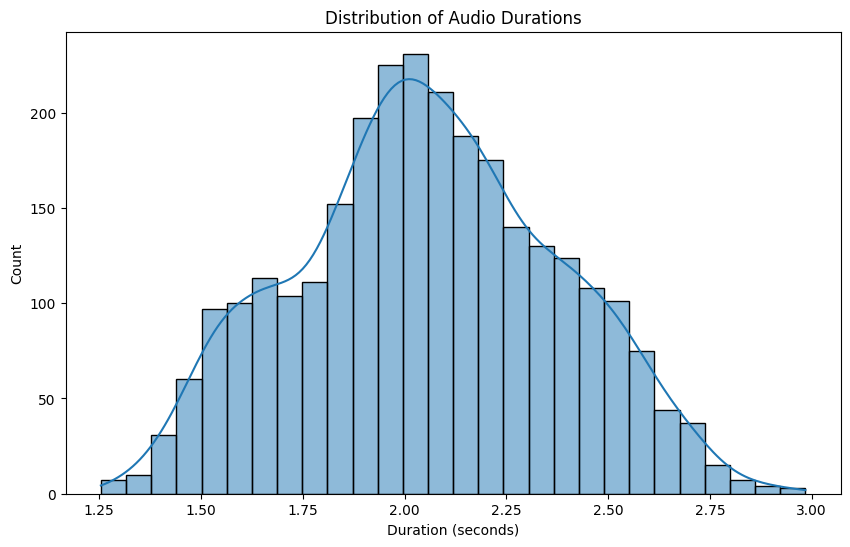

In [12]:
# Histogram of audio durations
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['duration'], kde=True)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

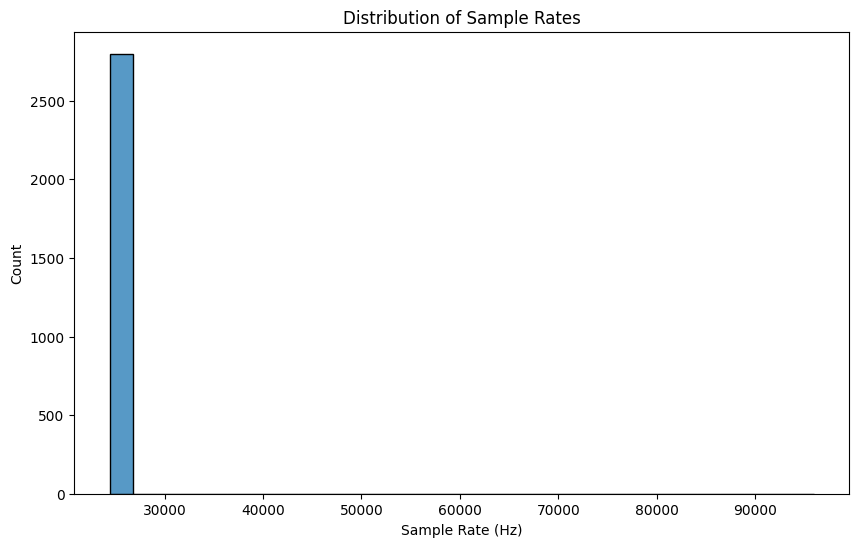

In [13]:
# Histogram of sample rates
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['sample_rate'], bins=30, kde=False)
plt.title('Distribution of Sample Rates')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('Count')
plt.show()

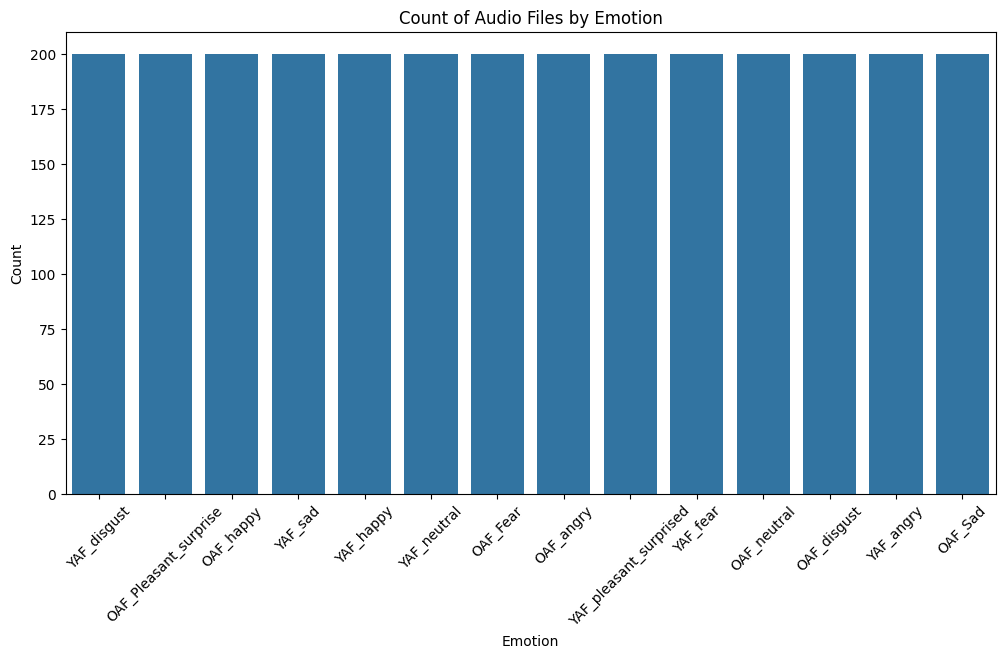

In [14]:
# Bar chart of file counts by emotion
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='emotion')
plt.title('Count of Audio Files by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

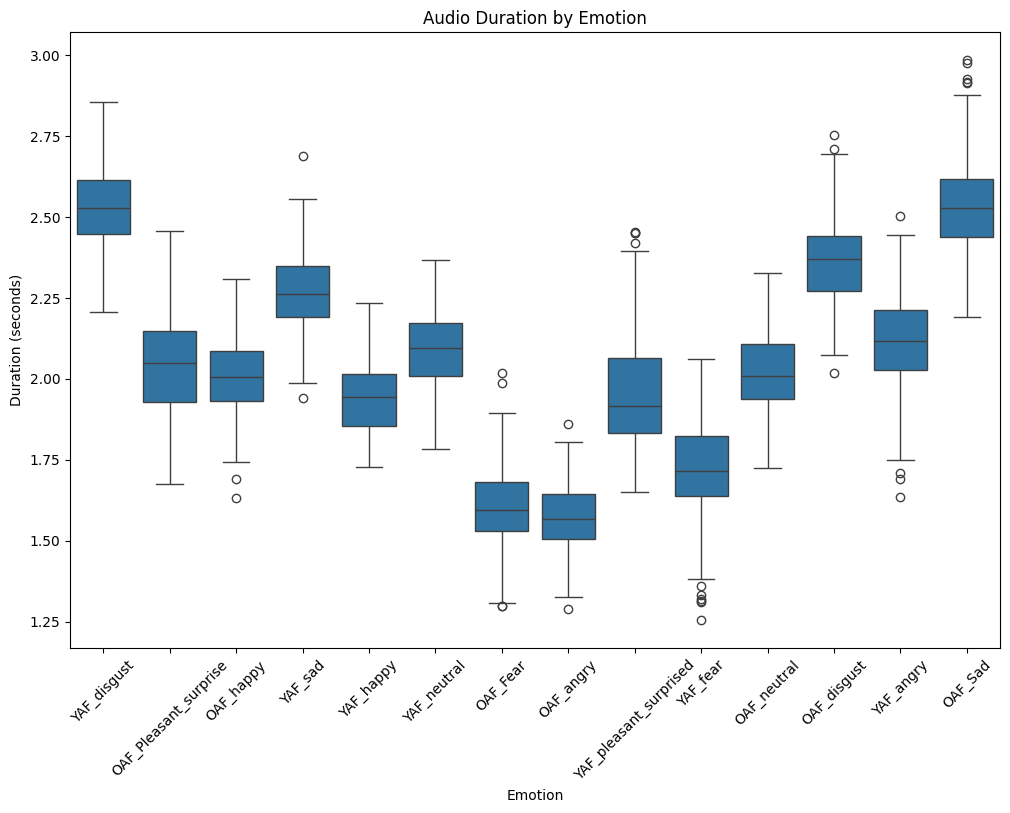

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clean, x='emotion', y='duration')
plt.title('Audio Duration by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

## Modeling

Feature Extraction
- Extracting features from your audio files using Mel-frequency cepstral coefficients (MFCCs) as features, which are commonly used in speech and audio processing tasks.

In [16]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, {e}")
        return None 
    return mfccs_processed

df['features'] = df['file_path'].apply(extract_features)

Data Preparation
- Preparing the dataset for training, including splitting training and testing sets, and encoding the labels.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# Split data
X = np.array(df['features'].tolist())
y = to_categorical(df['emotion_encoded'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Definition
- Defining a simple CNN model suited for 1D data like MFCCs.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 18, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 128)               1

Model Training

In [19]:
# Reshape X_train and X_test to add an extra dimension expected by Conv1D layers
X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped = X_test[..., np.newaxis]

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=30,  # The number of epochs to train for
    batch_size=32,  # The size of the batches of data
    validation_data=(X_test_reshaped, y_test)
)

Epoch 1/30
70/70 [==============================] - 1s 5ms/step - loss: 1.1610 - accuracy: 0.6415 - val_loss: 0.1852 - val_accuracy: 0.9679
Epoch 2/30
70/70 [==============================] - 0s 3ms/step - loss: 0.2883 - accuracy: 0.9062 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 3/30
70/70 [==============================] - 0s 3ms/step - loss: 0.1623 - accuracy: 0.9469 - val_loss: 0.0266 - val_accuracy: 0.9929
Epoch 4/30
70/70 [==============================] - 0s 5ms/step - loss: 0.1160 - accuracy: 0.9603 - val_loss: 0.0230 - val_accuracy: 0.9911
Epoch 5/30
70/70 [==============================] - 0s 4ms/step - loss: 0.0963 - accuracy: 0.9688 - val_loss: 0.0234 - val_accuracy: 0.9929
Epoch 6/30
70/70 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9786 - val_loss: 0.0191 - val_accuracy: 0.9929
Epoch 7/30
70/70 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9790 - val_loss: 0.0216 - val_accuracy: 0.9911
Epoch 8/30
70/70 [==

In [20]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}\nTest loss: {test_loss}")

18/18 - 0s - loss: 0.0099 - accuracy: 0.9946 - 31ms/epoch - 2ms/step
Test accuracy: 0.9946428537368774
Test loss: 0.00986635871231556


## Sample Prediction

In [21]:
# Defining the function to extract MFCC features from an audio file
def extract_features_for_prediction(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, {e}")
        return None 
    return mfccs_processed

def predict(file_path):
    new_audio_features = extract_features_for_prediction(file_path)

    # If feature extraction was successful, reshape the features and predict using the trained model
    if new_audio_features is not None:
        new_audio_features_reshaped = new_audio_features[np.newaxis, ..., np.newaxis]
        predicted_vector = model.predict(new_audio_features_reshaped)
        predicted_class = np.argmax(predicted_vector, axis=1)

        # Assuming the LabelEncoder 'le' is already fitted with the emotion labels
        predicted_emotion = le.inverse_transform(predicted_class)
        
        # Gets the predicted label as a string and cleans it by removing "OAF_" or "YAF_" prefix
        emotion_label = predicted_emotion[0]
        cleaned_emotion = emotion_label.split("_")[-1]
        
        print(f"The predicted emotion is: {cleaned_emotion}")
    else:
        print("Could not process audio file for prediction.")
    

In [22]:
file_path_to_predict = 'dataset/OAF_angry/OAF_back_angry.wav'

predict(file_path_to_predict)


1/1 [==============================] - 0s 102ms/step
The predicted emotion is: angry


Sample recording

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6fb82adf-34a9-4cc6-b667-fd5bc84832b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>